In [7]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import requests

# RETREIVE THE FX BASKETS

In [11]:
def basket(basket_name):
    email = "your@email.com"
    product_type = "currency_crosses"
    time_frame = "Daily"

    if basket_name == 'USD':
        names = ['AUD/USD','EUR/USD','GBP/USD','USD/JPY','USD/CHF','USD/CAD']
        
    elif basket_name == 'AUD':
        names = ['AUD/USD','EUR/AUD','GBP/AUD','AUD/JPY','AUD/CHF','AUD/CAD']
        
    elif basket_name == 'EUR':
        names = ['EUR/AUD','EUR/USD','EUR/GBP','EUR/JPY','EUR/CHF','EUR/CAD']    
    
    elif basket_name == 'JPY':
        names = ['AUD/JPY','GBP/JPY','EUR/JPY','CHF/JPY','CAD/JPY','USD/JPY']    
    
    elif basket_name == 'GBP':
        names = ['GBP/USD','GBP/AUD','GBP/JPY','GBP/CHF','GBP/CAD','EUR/GBP']    
    
    elif basket_name == 'CAD':
        names = ['AUD/CAD','USD/CAD','CAD/JPY','CAD/CHF','EUR/CAD','GBP/CAD']    
    
    elif basket_name == 'CHF':
        names = ['AUD/CHF','USD/CHF','CHF/JPY','CAD/CHF','EUR/CHF','GBP/CHF']        
        
    df = pd.DataFrame()
    
    # Get the current date
    current_date = datetime.now()

    # Check if today is a weekend (Saturday or Sunday)
    # If yes, get the last Friday
    if current_date.weekday() in [5, 6]:
        days_until_friday = current_date.weekday() - 4
        last_friday_date = current_date - timedelta(days=days_until_friday)
        from_date = (last_friday_date-timedelta(days = 100)).strftime('%m/%d/%Y')
        to_date = last_friday_date.strftime('%m/%d/%Y')
    else:
        from_date = (current_date-timedelta(days = 100)).strftime('%m/%d/%Y')
        to_date = current_date.strftime('%m/%d/%Y')
    
    
    for cross in names:
        name = cross
        params = {
            "email": email,
            "type": "historical_data",
            "product": product_type,
            "from_date": from_date,
            "to_date": to_date,
            "time_frame": time_frame,
            "name": name
        }
    
        response = requests.get("http://api.scraperlink.com/investpy/", params=params)
        data = response.json()
        a = pd.DataFrame(data['data'])[['rowDate','last_close']]
        a['rowDate'] = pd.to_datetime(a['rowDate'])
        a['last_close'] = a['last_close'].astype(float)
        a.columns = [cross+'_date',cross+'_close']
        
        df = pd.concat([df,a], axis = 1)
        
    return df

In [12]:
def date_check(df):
    # Check if all the dates are the same == no missing data
    column_arrays = [df[col].to_numpy() for col in df.columns[::2]]
    all_columns_are_identical = np.all([np.array_equal(column_arrays[0], col) for col in column_arrays[1:]])
    
    if all_columns_are_identical:
        df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
        df = df.set_index('Date')
        df = df[df.columns[0::2]]
    else:
        raise ValueError('NOT IDENTICAL')
        
    return df

Obtaining the basket of FX crosses

In [13]:
usd = basket('USD')
aud = basket('AUD')
eur = basket('EUR')
gbp = basket('GBP')
cad = basket('CAD')
chf = basket('CHF')
jpy = basket('JPY')

Running date check

In [14]:
dfs = [usd, aud, eur, gbp, cad, chf, jpy]
    
for i in range(len(dfs)):
    try:
        dfs[i] = date_check(dfs[i])
    except ValueError as e:
        print(e)
        break

In [15]:
names = ['USD','AUD','EUR','GBP','CAD','CHF','JPY']

for x in range(len(names)):
    dfs[x].to_pickle(names[x]+'.pkl')

In [16]:
usd = pd.read_pickle('USD.pkl')
aud = pd.read_pickle('AUD.pkl')
eur = pd.read_pickle('EUR.pkl')
gbp = pd.read_pickle('GBP.pkl')
cad = pd.read_pickle('CAD.pkl')
chf = pd.read_pickle('CHF.pkl')
jpy = pd.read_pickle('JPY.pkl')

# Creating the basket indice


In [17]:
def indice(df, name):
    cols = df.columns
    for x in range(len(cols)):
        if cols[x][:3] != name:
            df[cols[x]] = 1/df[cols[x]]
    df = df.reset_index().sort_values(by = 'Date')
    df = df.set_index('Date')
    a = (df/df.shift(1))-1 # daily
    b = (df/df.shift(5))-1 # weekly
    c = (df/df.shift(20))-1 # monthly
    d = (df/df.shift(60))-1 # quarterly
    
    df[1]= a.mean(axis = 1)
    df[2]= b.mean(axis = 1)
    df[3]= c.mean(axis = 1)
    df[4]= d.mean(axis = 1)

    
    df = df[[1,2,3,4]].dropna()
    df.columns = [name+'_1Dpct',name+'_1Wpct',name+'_1Mpct',name+'_1Qpct']
    return df

In [18]:
usd_i = indice(usd.copy(),'USD')
aud_i = indice(aud.copy(),'AUD')
eur_i = indice(eur.copy(),'EUR')
gbp_i = indice(gbp.copy(),'GBP')
cad_i = indice(cad.copy(),'CAD')
chf_i = indice(chf.copy(),'CHF')
jpy_i = indice(jpy.copy(),'JPY')

In [19]:
# OPTIONAL TO PICKLE
#usd_i.to_pickle('USD_indice.pkl')
#aud_i.to_pickle('AUD_indice.pkl')
#eur_i.to_pickle('EUR_indice.pkl')
#gbp_i.to_pickle('GBP_indice.pkl')
#cad_i.to_pickle('CAD_indice.pkl')
#chf_i.to_pickle('CHF_indice.pkl')
#jpy_i.to_pickle('JPY_indice.pkl')

In [20]:
# OPTIONAL LOAD PICKLE
#usd_i = pd.read_pickle('USD_indice.pkl')
#aud_i = pd.read_pickle('AUD_indice.pkl')
#eur_i = pd.read_pickle('EUR_indice.pkl')
#gbp_i = pd.read_pickle('GBP_indice.pkl')
#cad_i = pd.read_pickle('CAD_indice.pkl')
#chf_i = pd.read_pickle('CHF_indice.pkl')
#jpy_i = pd.read_pickle('JPY_indice.pkl')

In [21]:
# Merging all indices
basket = pd.concat([usd_i,aud_i,eur_i,gbp_i,cad_i,chf_i,jpy_i], axis = 1)

# check no dates were dropped
len(usd_i) == len(basket)

True

In [22]:
# Get the biggest Winner and Loser
# Per: each timeframe
d_col = basket.columns[::4]
w_col = basket.columns[1::4]
m_col = basket.columns[2::4]
q_col = basket.columns[3::4]

# Assign points per D, W, M, Q for each of the 7 FXs (highest point = leader, lowest = laggard)
point_d = basket[d_col].rank(axis = 1, ascending= True)
point_w = basket[w_col].rank(axis = 1, ascending= True)
point_m = basket[m_col].rank(axis = 1, ascending= True)
point_q = basket[q_col].rank(axis = 1, ascending= True)

In [23]:
# Identify Short Term Leader/Laggard and Long Term Leader/Laggard
st = pd.DataFrame()
lt = pd.DataFrame()

for i in range(len(point_d.columns)):
    col1 = point_d.iloc[:, i]
    col2 = point_w.iloc[:, i]
    result_col_name = point_d.columns[i][:3]  
    st[result_col_name] = col1 + col2
    col1 = point_m.iloc[:, i]
    col2 = point_q.iloc[:, i]
    result_col_name = point_m.columns[i][:3]
    lt[result_col_name] = col1 + col2   
    
    
st = pd.concat([st,st.idxmax(axis = 1),st.idxmin(axis = 1)], axis = 1)
st.rename(columns={0: 'ST_Lead' ,1:'ST_Lag'}, inplace = True)

lt = pd.concat([lt,lt.idxmax(axis = 1),lt.idxmin(axis = 1)], axis = 1)
lt.rename(columns={0: 'LT_Lead' ,1:'LT_Lag'}, inplace = True)

In [24]:
# CREATE A MARKET SCANNER WITH LEAD AND LAG, IDENTIFY ST + LT ALIGNMENT
scanner = pd.concat([st[st.columns[-2:]],lt[lt.columns[-2:]]], axis = 1)
scanner['Long'] = np.where(scanner['ST_Lead']==scanner['LT_Lead'],scanner['LT_Lead'],'None')
scanner['Short'] = np.where(scanner['ST_Lag']==scanner['LT_Lag'],scanner['LT_Lag'],'None')

# Long: Best Lead FX Cross

In [25]:
def lead(lead):
    if lead == 'USD':
        df = usd.copy()
    elif lead == 'EUR':
        df = eur.copy()
    elif lead == 'AUD':
        df = aud.copy()
    elif lead == 'JPY':
        df = jpy.copy()
    elif lead == 'GBP':
        df = gbp.copy()
    elif lead == 'CAD':
        df = cad.copy()
    elif lead == 'CHF':
        df = chf.copy()
    
    cols = df.columns
    for x in range(len(cols)):
        if cols[x][:3] != lead:
            df[cols[x]] = 1 / df[cols[x]]
    
    df = df.reset_index().sort_values(by='Date')
    df = df.set_index('Date')
    
    df = ((df / df.shift(1)) - 1).dropna()
    idxmax_result = df.idxmax(axis=1)
    
    def generate_output(row):
        if row[:3] != lead:
            return row[4:7] + '/' + row[0:3]
        else:
            return row[:7]
    
    df = idxmax_result.apply(generate_output)
    return df

In [26]:
# Initialize an empty list to store the results
long_results = []

# Iterate through DataFrame rows and apply the lead function
for index, row in scanner.iterrows():
    if row['Long'] != 'None':
        result = lead(row['Long']).reindex([index]).values[0]
    else:
        result = 'None'
    long_results.append(result)
    
    
scanner['Long_Result'] = long_results

# Short: Worst Lag FX Cross

In [27]:
def lag(lag):
    if lag == 'USD':
        df = usd.copy()
    elif lag == 'EUR':
        df = eur.copy()
    elif lag == 'AUD':
        df = aud.copy()
    elif lag == 'JPY':
        df = jpy.copy()
    elif lag == 'GBP':
        df = gbp.copy()
    elif lag == 'CAD':
        df = cad.copy()
    elif lag == 'CHF':
        df = chf.copy()
    
    cols = df.columns
    for x in range(len(cols)):
        if cols[x][:3] != lead:
            df[cols[x]] = 1 / df[cols[x]]
    
    df = df.reset_index().sort_values(by='Date')
    df = df.set_index('Date')
    
    df = ((df / df.shift(1)) - 1).dropna()
    idxmin_result = df.idxmin(axis=1)
    
    def generate_output(row):
        if row[:3] != lead:
            return row[4:7] + '/' + row[0:3]
        else:
            return row[:7]
    
    df = idxmin_result.apply(generate_output)
    return df

In [28]:
# Initialize an empty list to store the results
short_results = []

# Iterate through DataFrame rows and apply the lead function
for index, row in scanner.iterrows():
    if row['Short'] != 'None':
        result = lead(row['Short']).reindex([index]).values[0]
    else:
        result = 'None'
    short_results.append(result)
    
    
scanner['Short_Result'] = short_results

OUTPUT

In [29]:
program = scanner.copy()

# TODAY'S STRONGEST CURRENCY

In [37]:
current_date = datetime.now()
to_date = current_date.strftime('%m/%d/%Y')
bull = pd.DataFrame(program.iloc[-1,0::2]).reset_index().copy()
bull['index'] = ['Momentum','Trend','Strength','Long Trade']
bull.columns = ['Strongest',to_date]
bull = bull.set_index('Strongest')
bull

,10/15/2023
Strongest,
Momentum,CHF
Trend,USD
Strength,None
Long Trade,None


# TODAY'S WEAKEST CURRENCY

In [38]:
bear = pd.DataFrame(program.iloc[-1,1::2]).reset_index().copy()
bear['index'] = ['Momentum','Trend','Strength','Short Trade']
bear.columns = ['Weakest',to_date]
bear = bear.set_index('Weakest')
bear

,10/15/2023
Weakest,
Momentum,AUD
Trend,AUD
Strength,AUD
Short Trade,AUD/GBP


# STRONGEST CURRENCY: OVER THE WEEK

In [32]:
bull_2 = pd.DataFrame(program.iloc[-5:,0::2]).reset_index().copy()
bull_2['Date'] = bull_2['Date'].astype(str)
bull_2 = bull_2.transpose().reset_index()
bull_2['index'] = ['Strongest','Momentum','Trend','Strength','Long Trade']
order = bull_2.iloc[0].sort_values(ascending = False)[1:].tolist()
bull_2.columns = bull_2.iloc[0]
bull_2 = bull_2.iloc[1:]
bull_2 = bull_2.set_index('Strongest')
bull_2 = bull_2[order]
bull_2

,2023-10-13,2023-10-12,2023-10-11,2023-10-10,2023-10-09
Strongest,,,,,
Momentum,CHF,USD,CHF,AUD,JPY
Trend,USD,USD,USD,USD,USD
Strength,None,USD,None,None,None
Long Trade,None,USD/AUD,None,None,None


# WEAKEST CURRENCY: OVER THE WEEK

In [33]:
bear_2 = pd.DataFrame(program.iloc[-5:,1::2]).transpose().reset_index().copy()
bear_2['index'] = ['Momentum','Trend','Strength','Short Trade']
bear_2.columns = ['Weakest','T-4','T-3','T-2','T-1','Today']
bear_2 = bear_2[['Weakest','Today','T-1','T-2','T-3','T-4']]
bear_2 = bear_2.set_index('Weakest')
bear_2

,Today,T-1,T-2,T-3,T-4
Weakest,,,,,
Momentum,AUD,AUD,JPY,USD,USD
Trend,AUD,AUD,JPY,GBP,GBP
Strength,AUD,AUD,JPY,None,None
Short Trade,AUD/GBP,AUD/GBP,JPY/AUD,None,None


# VISUALIZING STRONG CURRENCIES

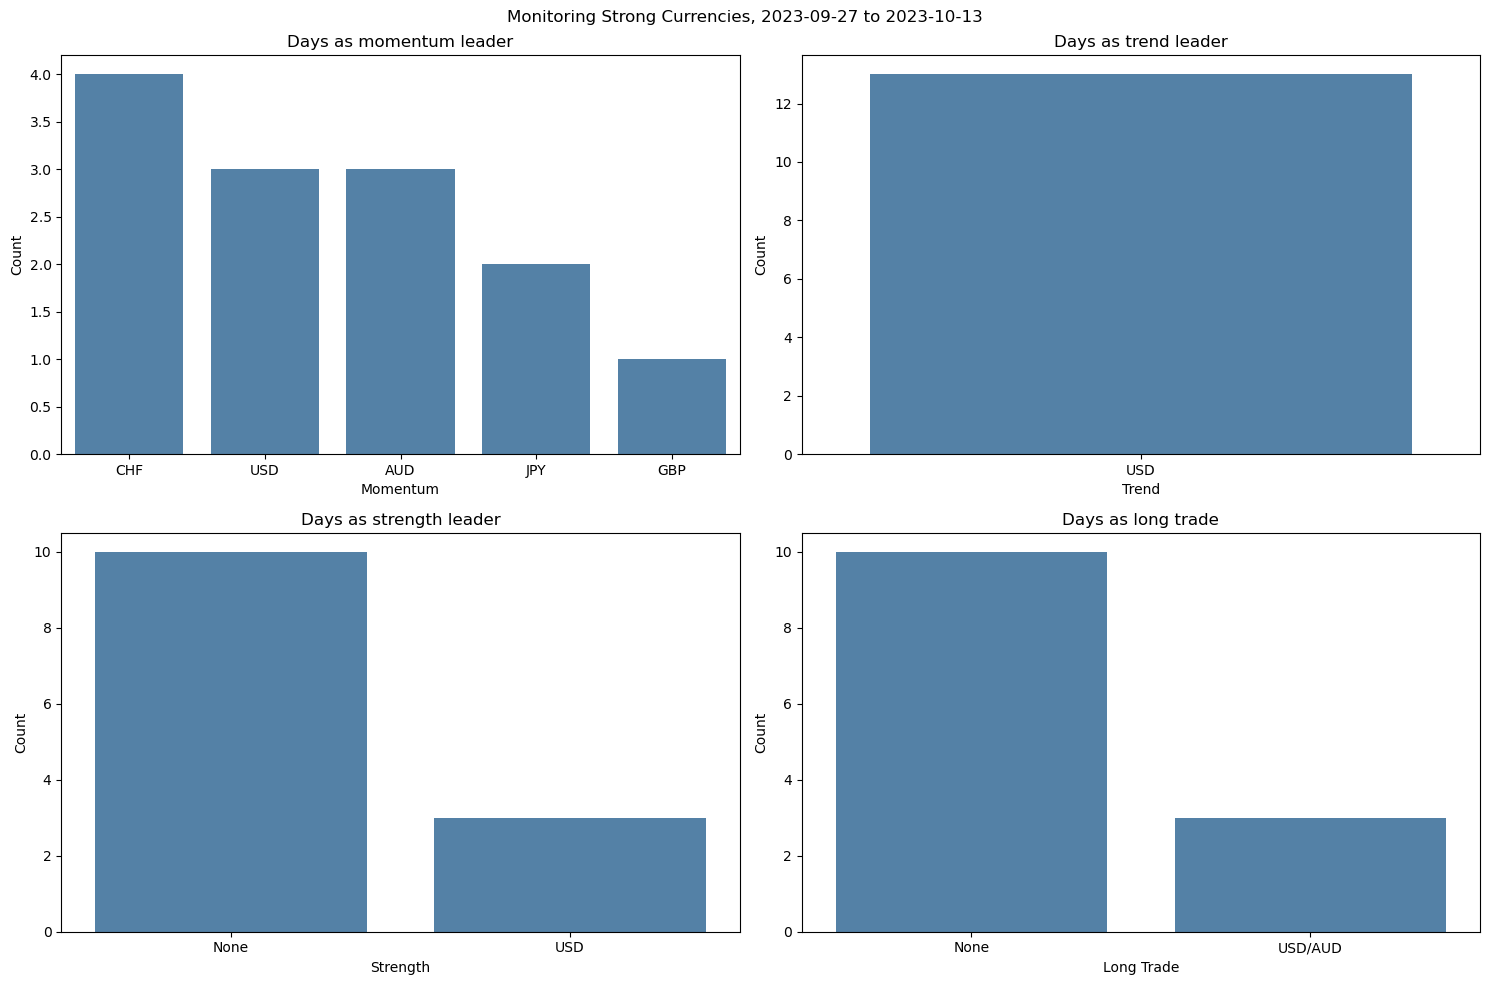

In [34]:
strong = program.reset_index().copy()
strong = strong[strong.columns[1::2]]

var1 = 'Momentum'
var2 = 'Trend'
var3 = 'Strength'
var4 = 'Long Trade'

# Plotting the subplots
fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))

# Risk 1 (top left)
axs[0,0].set_title('Days as momentum leader')
# Risk 2 (top right)
axs[0,1].set_title('Days as trend leader')
#Risk 3 (bottom left)
axs[1,0].set_title('Days as strength leader')
# Risk 4 (bottom right)
axs[1,1].set_title('Days as long trade')

# Creating the subplots
momo = strong[strong.columns[0]].value_counts().reset_index()
momo.columns = [var1,'Count']
plot1 = sns.barplot(data = momo, x = var1, y = 'Count', order = momo[var1], ax = axs[0,0], color = 'steelblue')

trend = strong[strong.columns[1]].value_counts().reset_index()
trend.columns = [var2,'Count']
plot2 = sns.barplot(data = trend, x =var2, y = 'Count', order = trend[var2], ax = axs[0,1], color = 'steelblue')

strength = strong[strong.columns[2]].value_counts().reset_index()
strength.columns = [var3,'Count']
plot3 = sns.barplot(data = strength, x =var3, y = 'Count', order = strength[var3], ax = axs[1,0], color = 'steelblue')

long = strong[strong.columns[3]].value_counts().reset_index()
long.columns = [var4,'Count']
plot4 = sns.barplot(data = long, x =var4, y = 'Count', order = long[var4], ax = axs[1,1], color = 'steelblue')

plt.suptitle('Monitoring Strong Currencies, '+str(program.index.min())[:10]+' to '+ str(program.index.max())[:10])
plt.tight_layout()

# VISUALIZING WEAK CURRENCIES

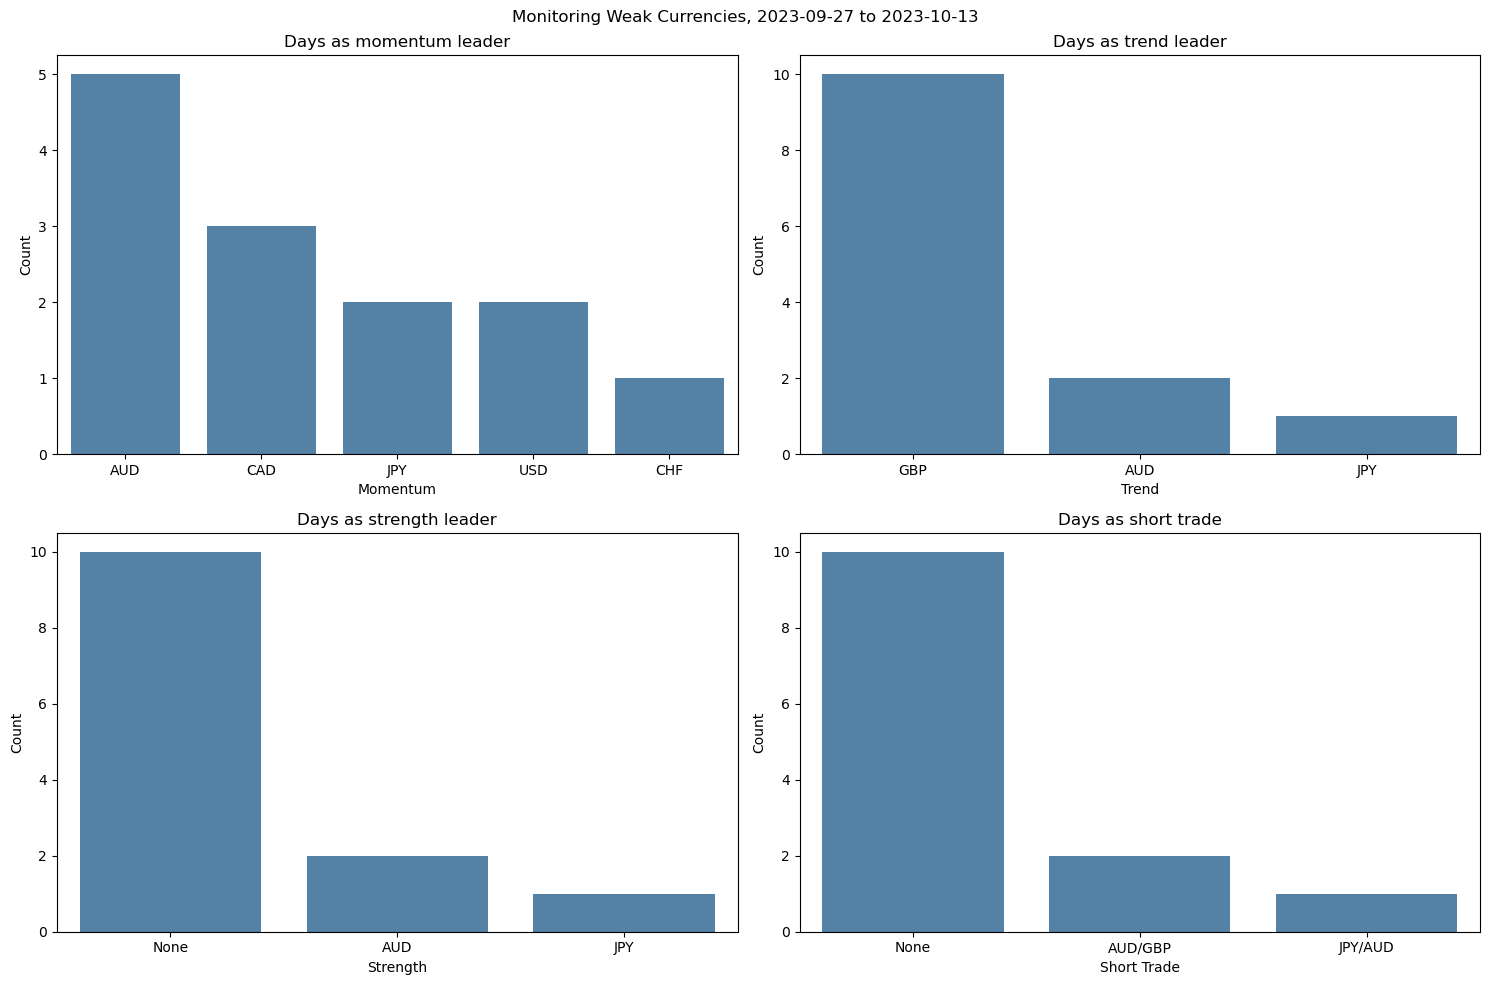

In [35]:
weak = program.reset_index().copy()
weak = weak[weak.columns[2::2]]

var1 = 'Momentum'
var2 = 'Trend'
var3 = 'Strength'
var4 = 'Short Trade'

# Plotting the subplots
fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))

# Risk 1 (top left)
axs[0,0].set_title('Days as momentum leader')
# Risk 2 (top right)
axs[0,1].set_title('Days as trend leader')
#Risk 3 (bottom left)
axs[1,0].set_title('Days as strength leader')
# Risk 4 (bottom right)
axs[1,1].set_title('Days as short trade')

# Creating the subplots
momo = weak[weak.columns[0]].value_counts().reset_index()
momo.columns = [var1,'Count']
plot1 = sns.barplot(data = momo, x = var1, y = 'Count', order = momo[var1], ax = axs[0,0], color = 'steelblue')

trend = weak[weak.columns[1]].value_counts().reset_index()
trend.columns = [var2,'Count']
plot2 = sns.barplot(data = trend, x =var2, y = 'Count', order = trend[var2], ax = axs[0,1], color = 'steelblue')

strength = weak[weak.columns[2]].value_counts().reset_index()
strength.columns = [var3,'Count']
plot3 = sns.barplot(data = strength, x =var3, y = 'Count', order = strength[var3], ax = axs[1,0], color = 'steelblue')

long = weak[weak.columns[3]].value_counts().reset_index()
long.columns = [var4,'Count']
plot4 = sns.barplot(data = long, x =var4, y = 'Count', order = long[var4], ax = axs[1,1], color = 'steelblue')

plt.suptitle('Monitoring Weak Currencies, '+str(program.index.min())[:10]+' to '+ str(program.index.max())[:10])
plt.tight_layout()